Code Starts Here

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics, Model
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import cv2
from google.colab.patches import cv2_imshow
from mpl_toolkits import mplot3d
import pywt
import librosa
import librosa.display
from PIL import Image

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
!pip install tensorflow_wavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow_addons.losses import ContrastiveLoss
import tensorflow_wavelets.Layers.DWT as DWT

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 3
CROP_TO = 32
HEIGHT = 32
WIDTH = 32
SEED = 26
PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005
CROP_TO_DWT = 64
dim_DWT = 1
WIDTH_DWT = 64
HEIGHT_DWT = 64
dwt_modes = 4

In [ ]:
path_to_data = "/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders"

In [ ]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [ ]:
img_dirs

['/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/N',
 '/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MS(Mitral Stinosis)',
 '/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MVP(Mitral Valve Prolapse)',
 '/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/AS(Aortic Stinosis)',
 '/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MR(Mitral Regurgitation)']

In [ ]:
img_dir_AS = []
for entry in os.scandir('/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/AS(Aortic Stinosis)'):
    img_dir_AS.append(entry.path)

img_dir_MR = []
for entry in os.scandir('/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MR(Mitral Regurgitation)'):
    img_dir_MR.append(entry.path)

img_dir_MS = []
for entry in os.scandir('/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MS(Mitral Stinosis)'):
    img_dir_MS.append(entry.path)

img_dir_MVP = []
for entry in os.scandir('/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/MVP(Mitral Valve Prolapse)'):
    img_dir_MVP.append(entry.path)

img_dir_N = []
for entry in os.scandir('/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/N'):
    img_dir_N.append(entry.path)

In [ ]:
img_dir_AS[1]

'/content/drive/MyDrive/Heart Disease Sound Signal Datasets Updated Folders/AS(Aortic Stinosis)/New_AS_002.wav'

In [ ]:
def image_loading_and_preprocessing(img_path,):
   signal , sr = librosa.load(img_path, sr=32000, mono=True)
   melspec = librosa.feature.melspectrogram(y=signal,sr=sr)
   melspec = librosa.power_to_db(melspec).astype(np.float32)
   Height = melspec.shape[0]
   Width = melspec.shape[1]
   img = Image.fromarray(melspec, "I")
   img.save("my.png")
   img = np.array(img)
   arr1 = img.reshape((Height,Width,1))
   arr2 = np.array(arr1, dtype='uint8') 
   resized_img = cv2.resize(arr2,(64,64))
   resized_img = resized_img.reshape((64,64,1))
   resized_img = tf.tile(resized_img, [1, 1, 3])
   return resized_img

In [ ]:
def image_loading_and_preprocessing_eval(img_path,):
   signal , sr = librosa.load(img_path, sr=32000, mono=True)
   melspec = librosa.feature.melspectrogram(y=signal,sr=sr)
   melspec = librosa.power_to_db(melspec).astype(np.float32)
   Height = melspec.shape[0]
   Width = melspec.shape[1]
   img = Image.fromarray(melspec, "I")
   img.save("my.png")
   img = np.array(img)
   arr1 = img.reshape((Height,Width,1))
   arr2 = np.array(arr1, dtype='uint8') 
   resized_img = cv2.resize(arr2,(32,32))
   resized_img = resized_img.reshape((32,32,1))
   resized_img = tf.tile(resized_img, [1, 1, 3])
   return resized_img

In [ ]:
X = [ ]
y = [ ]

for i in range(len(img_dir_AS)):
  image = image_loading_and_preprocessing(img_dir_AS[i])
  X.append(image)
  y.append(0)

for i in range(len(img_dir_MR)):
  image = image_loading_and_preprocessing(img_dir_MR[i])
  X.append(image)
  y.append(1)

for i in range(len(img_dir_MS)):
  image = image_loading_and_preprocessing(img_dir_MS[i])
  X.append(image)
  y.append(2)

for i in range(len(img_dir_MVP)):
  image = image_loading_and_preprocessing(img_dir_MVP[i])
  X.append(image)
  y.append(3)

for i in range(len(img_dir_N)):
  image = image_loading_and_preprocessing(img_dir_N[i])
  X.append(image)
  y.append(4)

In [ ]:
dataset = {}
dataset['X'] = X
dataset['y'] = y
dataset = pd.DataFrame(dataset)

In [ ]:
dataset_sample = dataset[dataset['y']==0]

In [ ]:
#dataset_sample.head(5)

In [ ]:
#Shuffling the rows
df = dataset.sample(frac = 1)

In [ ]:
#df.head(5)

In [ ]:
df.keys()

Index(['X', 'y'], dtype='object')

In [ ]:
X_shuffled = df['X']
y_shuffled = df['y']

In [ ]:
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
y_shuffled[:5]

485    2
251    1
216    1
801    4
919    4
Name: y, dtype: int64

In [ ]:
y_shuffled = list(y_shuffled)#Done to remove the original indexes
y_shuffled[:5]

[2, 1, 1, 4, 4]

In [ ]:
y_shuffled = np.array(y_shuffled)

In [ ]:
list(y_shuffled).count(0)

200

In [ ]:
list(y).count(0)

200

In [ ]:
X_shuffled = list(X_shuffled)#Done to remove the original indexes
X_shuffled = np.array(X_shuffled)

In [ ]:
X_shuffled.shape

(1000, 64, 64, 3)

In [ ]:
X_train,X_test,y_train,y_test  = train_test_split(X_shuffled , y_shuffled , test_size=0.2 , random_state=42)

In [ ]:
#Creating another version of X and y for evaluation
X_eval = [ ]
y_eval = [ ]

for i in range(len(img_dir_AS)):
  image = image_loading_and_preprocessing_eval(img_dir_AS[i])
  X_eval.append(image)
  y_eval.append(0)

for i in range(len(img_dir_MR)):
  image = image_loading_and_preprocessing_eval(img_dir_MR[i])
  X_eval.append(image)
  y_eval.append(1)

for i in range(len(img_dir_MS)):
  image = image_loading_and_preprocessing_eval(img_dir_MS[i])
  X_eval.append(image)
  y_eval.append(2)

for i in range(len(img_dir_MVP)):
  image = image_loading_and_preprocessing_eval(img_dir_MVP[i])
  X_eval.append(image)
  y_eval.append(3)

for i in range(len(img_dir_N)):
  image = image_loading_and_preprocessing_eval(img_dir_N[i])
  X_eval.append(image)
  y_eval.append(4)

dataset_eval = {}
dataset_eval['X'] = X_eval
dataset_eval['y'] = y_eval
dataset_eval = pd.DataFrame(dataset_eval)

df_eval = dataset_eval.sample(frac = 1)
X_eval_shuffled = df_eval['X']
y_eval_shuffled = df_eval['y']

#Done to remove the original indexes
X_eval_shuffled = list(X_eval_shuffled)
X_eval_shuffled = np.array(X_eval_shuffled)
y_eval_shuffled = list(y_eval_shuffled)#Done to remove the original indexes
y_eval_shuffled = np.array(y_eval_shuffled)

#Splitting into train and test for evaluation
X_train_eval,X_test_eval,y_train_eval,y_test_eval  = train_test_split(X_eval_shuffled , y_eval_shuffled , test_size=0.2 , random_state=42)

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def flip_random_crop_dwt(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO_DWT, CROP_TO_DWT, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def convert_to_grayscale(image):
  image = np.array(image) 
  image_grayscale = cv2.cvtColor(D_V1[i], cv2.COLOR_BGR2GRAY)
  return image_grayscale

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

def custom_augment_dwt(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop_dwt(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

In [ ]:
BATCH_SIZE_DWT = 64
ssl_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_one = (ssl_ds_one.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#Creating a Grayscale Version of the same Dataset-2
ssl_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
ssl_ds_two = (ssl_ds_two.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#We then zip both of these datasets.
ssl_ds_pretrain = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

In [ ]:
def cosine_similarity(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
input_shape = (None, 32, 32, 4)
input_shape_gs = (None,32,32,1)
def encoder_dwt():
    model = tf.keras.Sequential(
           [ 
             # Input and backbone.
             tf.keras.layers.Input((CROP_TO_DWT, CROP_TO_DWT, 3)),
             tf.keras.layers.InputLayer(input_shape = (WIDTH_DWT,HEIGHT_DWT,3)),
             tf.keras.layers.Conv2D(1, 3,activation='relu',padding="same",input_shape=input_shape_gs[1:]),
             DWT.DWT(name="haar",concat=0),
             #tf.keras.layers.Conv2D(4, 1024),
             tf.keras.layers.Conv2D(3, 4,activation='relu',padding="same",input_shape=input_shape[1:]),
             tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT , 3),weights=None, include_top=False, pooling='avg'), 
             tf.keras.layers.Dense(PROJECT_DIM),

             # Projection head.
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization()
           ] ,
           name = "Encoder"
    )
    return model


def predictor_dwt():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            tf.keras.layers.Input((PROJECT_DIM,)),
            tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [ ]:
class SSL_DWT(tf.keras.Model):
    def __init__(self, encoder_dwt,predictor_dwt):
        super(SSL_DWT,self).__init__()
        #self.model = model
        self.encoder = encoder_dwt
        self.predictor = predictor_dwt
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        #self.data1 = data1
        #self.data2 = data2

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data .
        ds_one , ds_two = data 

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            #loss = cosine_similarity(ds_one,ds_two)
            z1 , z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1 , p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = cosine_similarity(p1, z2)  
            loss += cosine_similarity(p2, z1) 
            loss = loss/2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Epoch 1/5
13/13 [==============================] - 170s 11s/step - loss: -0.3652
Epoch 2/5
13/13 [==============================] - 122s 9s/step - loss: -0.7485
Epoch 3/5
13/13 [==============================] - 124s 9s/step - loss: -0.8823
Epoch 4/5
13/13 [==============================] - 123s 9s/step - loss: -0.9204
Epoch 5/5
13/13 [==============================] - 122s 9s/step - loss: -0.9280


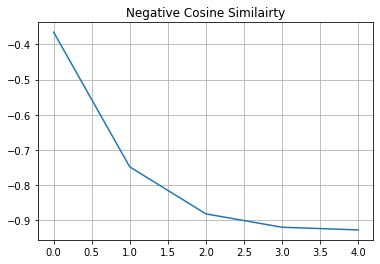

In [ ]:
EPOCHS = 5
num_training_samples = len(X_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
Final_Training_Model = SSL_DWT(encoder_dwt() , predictor_dwt() )
Final_Training_Model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = Final_Training_Model.fit(ssl_ds_pretrain , epochs=EPOCHS , callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

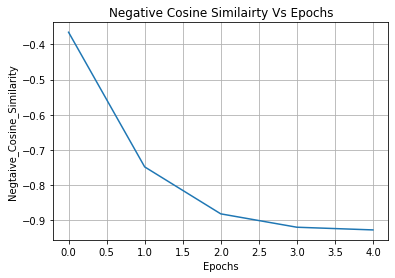

In [ ]:
# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.ylabel('Negtaive_Cosine_Similarity')
plt.xlabel('Epochs')
plt.title("Negative Cosine Similairty Vs Epochs")
plt.show()

In [ ]:
EPOCHS = 10
train_ds = tf.data.Dataset.from_tensor_slices((X_train_eval, y_train_eval))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_eval, y_test_eval))
# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (train_ds.shuffle(1024).map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet50
backbone = tf.keras.Sequential([tf.keras.layers.Input((CROP_TO, CROP_TO, 3)),
                                tf.keras.layers.InputLayer(input_shape = (WIDTH,HEIGHT,3)),
                                Final_Training_Model.encoder.get_layer("resnet50")])

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
#The Trained weights of the resnet layer is stored in x.
x = backbone(inputs, training=False)
#Then the x is the passed into a Dense layer with softmax activation function to get the final layer's weights.
outputs = layers.Dense(10, activation="softmax")(x)
#We now proceed to build our final linear model
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),)
history = linear_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]),
test_acc = linear_model.evaluate(test_ds)
#print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/15
13/13 [==============================] - 17s 823ms/step - loss: 916.3933 - accuracy: 0.1875 - val_loss: 748.3208 - val_accuracy: 0.1950
Epoch 2/15
13/13 [==============================] - 4s 296ms/step - loss: 1117.8206 - accuracy: 0.1925 - val_loss: 1337.4128 - val_accuracy: 0.1750
Epoch 3/15
13/13 [==============================] - 5s 422ms/step - loss: 1261.4952 - accuracy: 0.2150 - val_loss: 954.7783 - val_accuracy: 0.2250
Epoch 4/15
13/13 [==============================] - 5s 385ms/step - loss: 853.2183 - accuracy: 0.1950 - val_loss: 977.4105 - val_accuracy: 0.1950
Epoch 5/15
13/13 [==============================] - 4s 347ms/step - loss: 697.2146 - accuracy: 0.2050 - val_loss: 742.0377 - val_accuracy: 0.1750
Epoch 6/15
13/13 [==============================] - 6s 511ms/step - loss: 722.1813 - accuracy: 0.2212 - val_loss: 906.8786 - val_accuracy: 0.2000
Epoch 7/15
13/13 [==============================] - 4s 294ms/step - loss: 860.6091 - accuracy: 0.2000 - val_loss: 979.41

In [ ]:
print("Test accuracy: {:.2f}%".format(test_acc[1] * 100))

Test accuracy: 19.50%


In [ ]:
test_acc

[742.0377197265625, 0.19499999701976775]

Code Ends Here

Dataset Debugging 

In [ ]:
path_to_data = "C:\\Users\\harik\\Downloads\\ML_Celebritiy_Classification_Project\\Original Data"

Librosa Sound Signal To Image Testing(We just check if Librosa is working or not).

In [ ]:
import librosa
import numpy as np
y, sr = librosa.load('/content/New_AS_001.wav', sr=32000, mono=True)
#melspec = librosa.feature.melspectrogram(y, sr=sr, n_mels = 128)
melspec = librosa.feature.melspectrogram(y=y,sr=sr)#, sr=sr, n_mels = 128)
melspec = librosa.power_to_db(melspec).astype(np.float32)

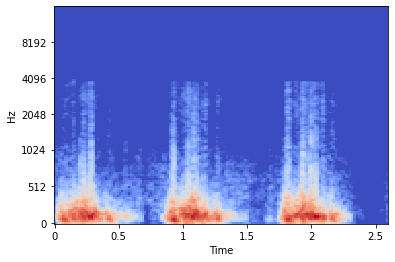

In [ ]:
import librosa.display
librosa.display.specshow(melspec, x_axis='time',  y_axis='mel', sr=sr, fmax=16000)

In [ ]:
melspec

array([[-32.43567   , -16.689938  ,  -0.12481511, ..., -41.927773  ,
        -41.927773  , -41.927773  ],
       [-17.421162  ,  -1.7984091 ,  11.803228  , ..., -41.927773  ,
        -41.316296  , -33.695045  ],
       [-15.594617  ,   7.5110874 ,  18.178734  , ..., -41.927773  ,
        -41.927773  , -34.742256  ],
       ...,
       [-41.927773  , -41.927773  , -41.927773  , ..., -41.927773  ,
        -41.927773  , -41.927773  ],
       [-41.927773  , -41.927773  , -41.927773  , ..., -41.927773  ,
        -41.927773  , -41.927773  ],
       [-41.927773  , -41.927773  , -41.927773  , ..., -41.927773  ,
        -41.927773  , -41.927773  ]], dtype=float32)

In [ ]:
melspec.shape

(128, 163)

In [ ]:
from PIL import Image
img = Image.fromarray(melspec, "I")
img.save("my.png")

In [ ]:
img = np.array(img)
img.shape

(128, 163)

In [ ]:
arr1 = img.reshape(-1)

In [ ]:
arr1.shape

(20864,)

In [ ]:
arr1 = arr1.reshape((128,163,1))

In [ ]:
arr1.shape

(128, 163, 1)

In [ ]:
arr2 = np.array(arr1, dtype='uint8') 

In [ ]:
import cv2
resized_img = cv2.resize(arr2,(64,64))

In [ ]:
resized_img = cv2.resize(arr2,(64,64))
resized_img = resized_img.reshape((64,64,1))

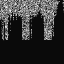

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(resized_img)

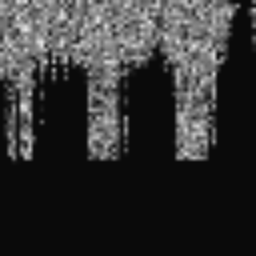

In [ ]:
scaled_img = cv2.resize(resized_img,(256,256))
scaled_img = scaled_img.reshape((256,256,1))
cv2_imshow(scaled_img)